# GCRA

Rate limiting with the [Generic Cell Rate Algorithim](https://en.wikipedia.org/wiki/Generic_cell_rate_algorithm)

In [105]:
from copyreg import dispatch_table

from generic_cell_rate_algorithm.throttle import RateLimit

# Create mock data stores

RATE_LIMIT_DB = {"count": 100, "period": 60}
THROTTLE_STATE_DB = [
    {"level": 0, "tat": 0, "allocation": 50},
    {"level": 0, "tat": 0, "allocation": 50},
    {"level": 1, "tat": 0, "allocation": 50},
    {"level": 2, "tat": 0, "allocation": 25},
    {"level": 3, "tat": 0, "allocation": 10},
]

In [106]:
from generic_cell_rate_algorithm import throttle


# define our data store interfaces
class RateLimitDB(throttle.RateLimitIO):
    def __init__(self, rate_limit_db):
        self.db = rate_limit_db

    def read(self):
        return throttle.RateLimit(count=self.db['count'], period=self.db['period'])


class ThrottleDB(throttle.ThrottleStateIO):
    def __init__(self, throttle_db):
        self.db = throttle_db

    def read(self):
        result = list()
        for id, row in enumerate(self.db):
            state = throttle.ThrottleState(
                tat=row['tat'],
                level=row['level'],
                allocation=row['allocation'],
                id=id
            )
            result.append(state)
        return result

    def write(self, previous, new):
        self.db[previous.id]['tat'] = new.tat


rate_limit_db = RateLimitDB(RATE_LIMIT_DB)
throttle_db = ThrottleDB(THROTTLE_STATE_DB)

print(rate_limit_db.read())
print(throttle_db.read())

RateLimit(count=100, period=60)
[ThrottleState(tat=0, level=0, allocation=50, id=0), ThrottleState(tat=0, level=0, allocation=50, id=1), ThrottleState(tat=0, level=1, allocation=50, id=2), ThrottleState(tat=0, level=2, allocation=25, id=3), ThrottleState(tat=0, level=3, allocation=10, id=4)]


In [169]:
# Create a fake instance of time that allows us to have instant gratification
from tests.conftest import TimeWarp

time = TimeWarp()

# Create a real instance of time
# import time

# Logger for viewing throttling
class TimeCard:
    def __init__(self):
        self._x0 = None
        self.log = list()

    def __call__(self):
        t = time.time()
        self._x0 = self._x0 or t
        self.log.append(t - self._x0)

    def clear(self):
        self._x0 = None
        self.log = list()

    @property
    def count(self):
        return np.arange(len(self.log))

    @property
    def time(self):
        return np.array(self.log)

    @property
    def rate(self):
        return self.count/np.maximum(1e-3, self.time)

time_card = TimeCard()

In [170]:
# Create our limiter instance
grca = throttle.GCRA(rate_limit_db, throttle_db, time)


def fn(level: int):
    @grca.throttle(level=level)
    def _fn():
        time_card()
        return None
    return _fn()

In [171]:
import matplotlib.pyplot as plt
import numpy as np

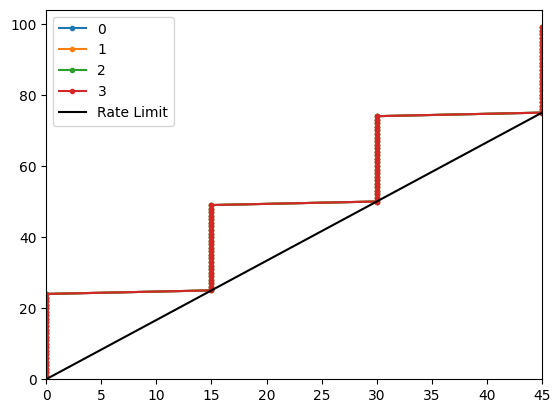

In [172]:
for level in range(4):
    time_card.clear()
    for _ in range(100):
        fn(level=level)
    plt.plot(time_card.time, time_card.count, '.-', label=level)


rate_limit = rate_limit_db.read()
plt.plot(time_card.time, time_card.time * rate_limit.rate, label="Rate Limit", color='k')
plt.xlim(0, time_card.time[-1])
plt.ylim(0, None)
plt.legend()
plt.show()

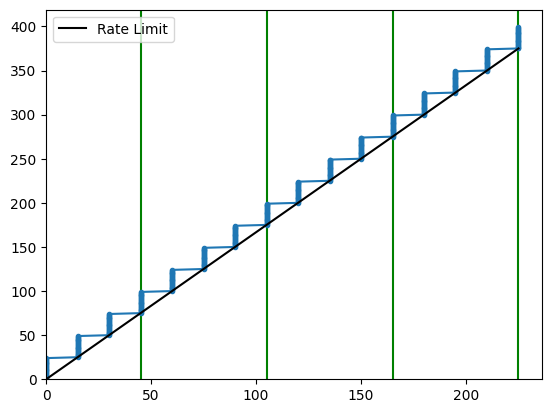

In [173]:
time_card.clear()
for level in range(4):
    for _ in range(100):
        fn(level=level)
    plt.axvline(time_card.time[-1], color='green')

plt.plot(time_card.time, time_card.count, '.-')

rate_limit = rate_limit_db.read()
plt.plot(time_card.time, time_card.time * rate_limit.rate, label="Rate Limit", color='k')
plt.xlim(0, None)
plt.ylim(0, None)
plt.legend()
plt.show()

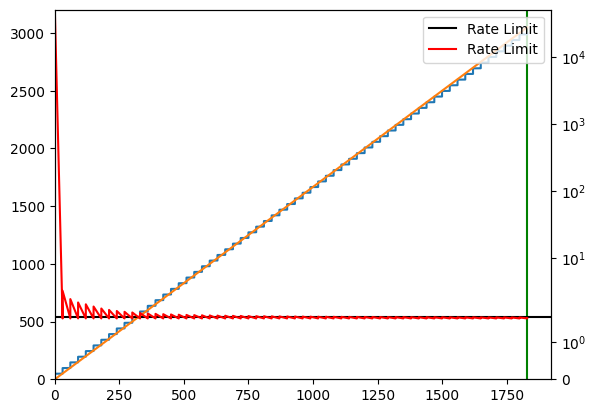

In [186]:
# Allow a burst of 25 calls while maintaining global limits
BURST_THROTTLE_STATE_DB = [{"level": 0, "tat": 0, "allocation": 100} for i in range(50)]
BURST_THROTTLE_STATE_DB[-1]['level'] = 100

throttle_db = ThrottleDB(BURST_THROTTLE_STATE_DB)
grca = throttle.GCRA(rate_limit_db, throttle_db, time)

def fn(level: int):
    @grca.throttle(level=level)
    def _fn():
        # time.sleep(1e-3)
        time_card()
        return None
    return _fn()


time_card.clear()

for _ in range(3000):
    fn(level=0)

plt.axvline(time_card.time[-1], color='green')
plt.plot(time_card.time, time_card.count, '-')
plt.plot(time_card.time, rate_limit.rate * time_card.time)
plt.xlim(0, None)
plt.ylim(0, None)

plt.twinx()
rate_limit = rate_limit_db.read()
plt.axhline(rate_limit.rate, label="Rate Limit", color='k')
plt.plot(time_card.time, time_card.rate, label="Rate Limit", color='red')

plt.ylim(0, None)
plt.yscale('symlog')
plt.legend()
plt.show()

In [187]:
throttle_db.read()

[ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=0),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=1),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=2),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=3),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=4),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=5),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=6),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=7),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=8),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=9),
 ThrottleState(tat=44242.689196799285, level=0, allocation=100, id=10),
 ThrottleState(tat=44212.689196799285, level=0, allocation=100, id=11),
 ThrottleState(tat=44212.689196799285, level=0, allocation=100, id=12),
 ThrottleState(tat=44212.689196799285, level=0, allocation=100, id=13),
 T

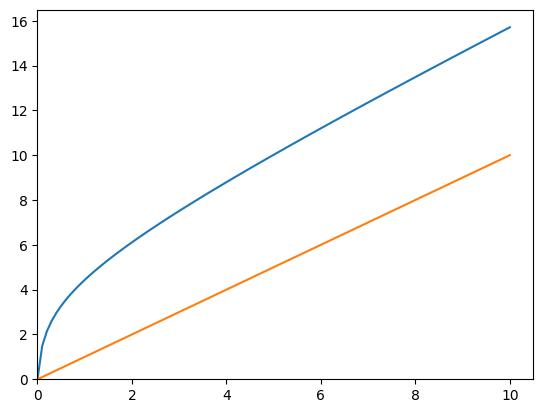

In [27]:

x = np.linspace(0, 10, 100)
f = np.log(30*x+1) + x

plt.plot(x, f)
plt.plot(x, x)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

# Placeholder for some work on variable rate limits

This is an interesting but vexing concept that allows the traversal of a rate limiting function based on accumulated wait time.

The idea is that with the additional storage of the current x of the rate function f(x)... We can continually adjust the rate limit to be "optimal" for a rate limiting system that has multiple rate limiting constraints.  For instance you could prioritize burst trafic at the expense of the longer term rate or prioritize smoothing traffic by reducing the burst trafic and maximizing the long term rate.



In [ ]:
class VariableRate:
    def __init__(self, burst_rate: RateLimit, sustained_rate: RateLimit):
        self.burst_rate = burst_rate
        self.sustained_rate = sustained_rate
        self._min = self.burst_rate.inverse
        self._max = self.sustained_rate.period
        self._x = self._min

        a = burst_rate.count
        b = burst_rate.period
        c = sustained_rate.count
        d = sustained_rate.period
        ln = math.log
        self._a = -(a*d - b * c) / (b*ln(d+1) - d*ln(b+1))
        self._b = -(c * ln(b+1) - a*ln(d+1))/(b*ln(d+1) - d*ln(b+1))

    def _count(self, x):
        return self._a * math.log(x + 1) + self._b * x

    def _rate(self, x):
        return self._a/(x + 1) + self._b

    def _inverse(self, x):
        return 1/self._rate(x)

    @property
    def count(self):
        return self._count(self._x)

    @property
    def period(self):
        return self._x

    @property
    def rate(self):
        return self._rate(self._x)

    @property
    def inverse(self):
        return self._inverse(self._x)

    def update(self, wait_time: float):
        self._x += min(wait_time, self.inverse)
        self._x = min(max(self._x, self._min), self._max)

In [26]:
from matplotlib import pyplot as plt
from generic_cell_rate_algorithm.throttle import RateLimit, GCRA
from tests.test_throttle import TimeWarp
import numpy as np

class UsageRateLimit:
    def __init__(self, rate: RateLimit):
        self._usage = 0
        self.rate = rate
        self._time_last = float('inf')

    @property
    def usage(self):
        return self._usage

    def use(self):
        if self.usage > self.rate.count:
            raise ResourceWarning(f"Usage limit exceeded: {self._usage}/{self.rate.count} over a {self.rate.period} period")
        self._usage += 1

    def roll_period(self, now):
        if self._time_last // self.rate.period != now // self.rate.period:
            self._usage = 0
        self._time_last = now



class MonitoredLimit:
    def __init__(self, *rate_limits: RateLimit):
        self.rate_limits = [UsageRateLimit(rl) for rl in rate_limits]

    def _roll_period(self, now: float):
        for rl in self.rate_limits:
            rl.roll_period(now)

    def _use(self):
        for rl in self.rate_limits:
            rl.use()

    def request(self):
        now = time.time()
        self._roll_period(now)
        self._use()

    def current_rates(self) -> list:
        rates = list()
        for rl in self.rate_limits:
            rate = RateLimit(count=rl.rate.count - rl.usage, period=rl.rate.period)
            rates.append(rate)
        return rates

    def rate(self) -> RateLimit:
        """ Get the rate with the fewest remaining counts """
        return min(self.current_rates(), key=lambda rl: rl.count)


burst = RateLimit(count=600, period=900)
sustained = RateLimit(count=6000, period=86400)

ml = MonitoredLimit(burst, sustained)

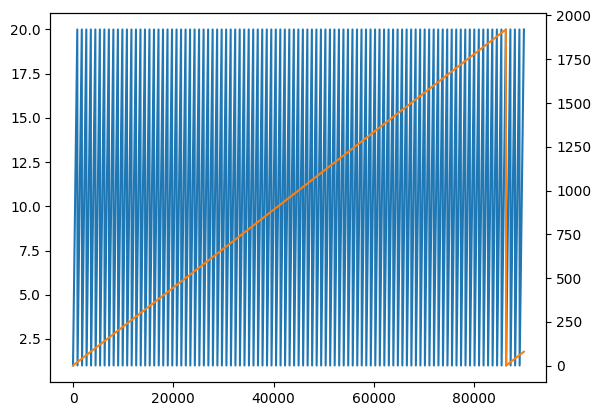

In [27]:
time = TimeWarp()
ml = MonitoredLimit(burst, sustained)

log = list()
for _ in range(2000):
    ml.request()
    log.append([time.time()] + [rl.usage for rl in ml.rate_limits])
    time.sleep(45)

t = [l[0] for l in log]
b = [l[1] for l in log]
s = [l[2] for l in log]

plt.plot(t, b)
plt.twinx()
plt.plot(t, s, color='C1')
plt.show()

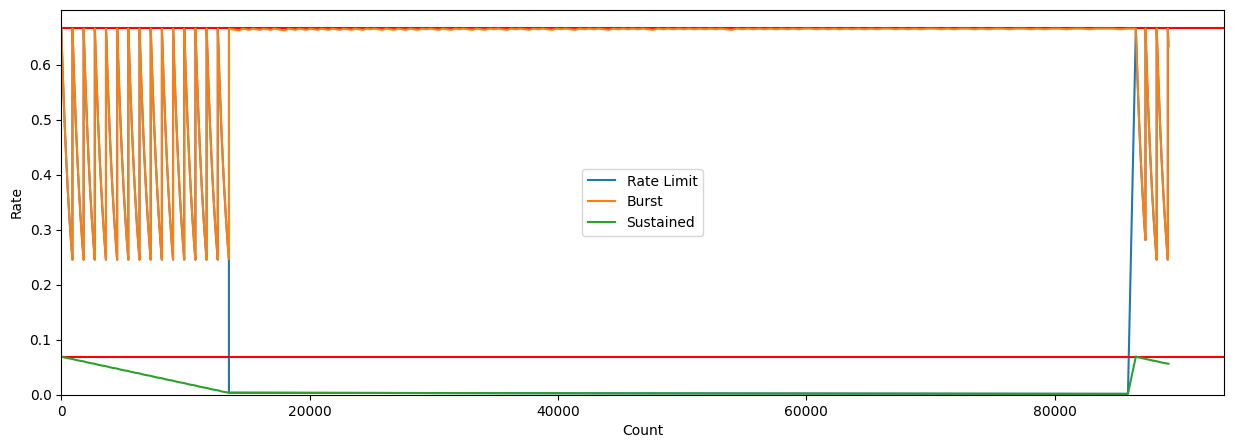

In [36]:
time = TimeWarp()
ml = MonitoredLimit(burst, sustained)
ml.rate()
log = list()
for _ in range(7000):
    rate_limit = ml.rate()
    log.append([time.time(), rate_limit.rate] + [rl.rate for rl in ml.current_rates()])
    # if rate_limit.count == 0:
    #     print('Exhausted resource, It has requested a infinite wait period')
    #     break
    time.sleep(rate_limit.inverse)
    ml.request()

t = [l[0] for l in log]
r = [l[1] for l in log]
b = [l[2] for l in log]
s = [l[3] for l in log]

plt.figure(figsize=(15, 5))
plt.plot(t, r, label="Rate Limit")
for rl in ml.rate_limits:
    plt.axhline(rl.rate.rate, color='red')
plt.plot(t, b, label="Burst")
plt.plot(t, s, label="Sustained")
plt.legend()
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Count")
plt.ylabel("Rate")
plt.show()

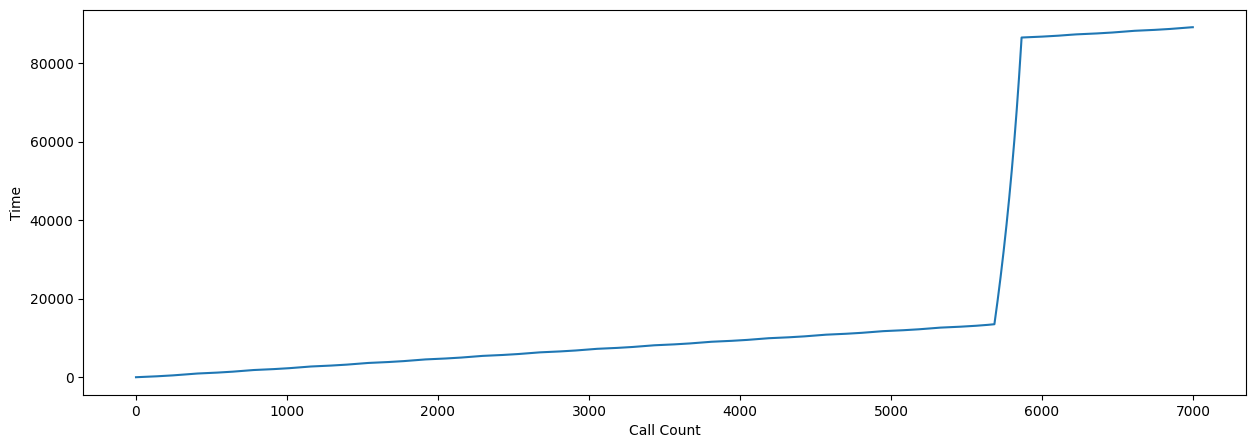

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(t)), t, '-')
plt.xlabel('Call Count')
plt.ylabel('Time')
plt.show()

In [38]:
from dataclasses import dataclass, field

@dataclass
class Test:
    a: int
    b: int = field(metadata={'frozen': True})

    def __setattr__(self, name, value):
        if name in self.__dataclass_fields__ and 'frozen' in self.__dataclass_fields__[name].metadata:
            raise AttributeError(f"cannot assign to frozen attribute '{name}'")
        super().__setattr__(name, value)


test = Test(1, 2)
test.a = 4
test

AttributeError: cannot assign to frozen attribute 'b'